## Important Imports

In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix

In [2]:
from test_functions import index_generator
from test_functions import load_labels
from test_functions import data_constructor
from test_functions import dataframe_generator
from test_functions import index_extractor
from test_functions import plot_confusion_matrix
from test_functions import phase1_labels_updater

## Setting up parameters and directories

In [3]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
DIM = (128,128)
TEST_SET= 25658
SEED=12 
label_file_test = "C:\project\data\\test_COVIDx_CT-2A.txt"

## Loading test data

FINAL IMAGE COUNT:
Total Training Images =  25658


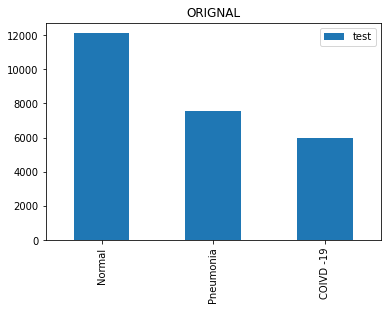

In [4]:
fnames_test , classes_test , bboxes_test = load_labels(label_file_test)
test_index = index_generator(fnames_test , TEST_SET)
df = dataframe_generator(test_index,classes_test)
df.plot.bar( title = "ORIGNAL" );
print("FINAL IMAGE COUNT:")
print("Total Training Images = ",len(test_index))

### Loading images for Phase - 1 testing

In [5]:
densenet_x, densenet_y = data_constructor(fnames_test,classes_test, DIM , index  =test_index , bboxes = bboxes_test)
densenet_x = tf.keras.applications.densenet.preprocess_input(densenet_x)
desnenet_y = phase1_labels_updater(densenet_y)
densenet_x.shape , densenet_y.shape

((25658, 128, 128, 3), (25658,))

### Loading Phase-1 Trained Model

In [6]:
phase1_model = tf.keras.models.load_model("models/phase-1.h5")
densenet = phase1_model.evaluate(densenet_x, densenet_y)

25658/25658 [==============================] - 72s 3ms/sample - loss: 0.0972 - accuracy: 0.9839


### Predicting NON-COVID and COVID-19

In [7]:
densenet_preds = phase1_model.predict(densenet_x)
densenet_preds = np.rint(densenet_preds).astype("int")
densenet_preds= densenet_preds.reshape(TEST_SET)

## CONFUSION MATRIX of PHASE -1 

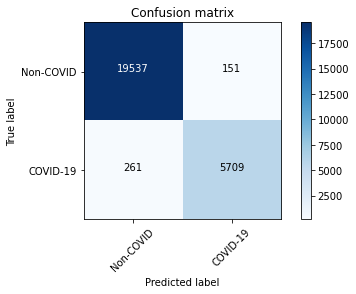

In [8]:
cm1 = confusion_matrix(densenet_y ,densenet_preds)
plot_confusion_matrix(cm1,["Non-COVID","COVID-19"] )

### Extracting index for Phase-2 Testing

In [9]:
index_0,index_02,index_20,index_21 = index_extractor(densenet_preds, densenet_y,  test_index ,classes_test)

### Passing True Positive from result of Phase-1 Testing to Phase-2 model

In [10]:
inception_x, inception_y = data_constructor(fnames_test,classes_test, DIM , index  =index_0 , bboxes = bboxes_test)
inception_x = tf.keras.applications.inception_v3.preprocess_input(inception_x)
inception_x.shape , inception_y.shape

((19537, 128, 128, 3), (19537,))

In [11]:
phase2_model = tf.keras.models.load_model("models/phase-2.h5")
inception = phase2_model.evaluate(inception_x , inception_y)

19537/19537 [==============================] - 28s 1ms/sample - loss: 8.4858e-04 - accuracy: 0.9998


### Predicting Normal and Pnumonia 

In [12]:
inception_preds = phase2_model.predict(inception_x)
inception_preds = np.rint(inception_preds).astype("int")
inception_preds = inception_preds.reshape(len(index_0))

## CONFUSION MATRIX of PHASE -2

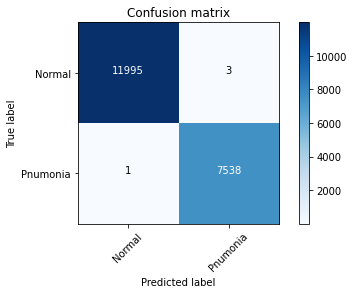

In [13]:
cm2 = confusion_matrix(inception_y ,inception_preds )
plot_confusion_matrix(cm2,["Normal","Pnumonia"] )

### Passing False Positives from Phase-1 to Phase-2 model

In [14]:
FN_x, FN_y = data_constructor(fnames_test,classes_test, DIM , index  =index_02 , bboxes = bboxes_test)
FN_x = tf.keras.applications.inception_v3.preprocess_input(FN_x)
FN_x.shape , FN_y.shape

((261, 128, 128, 3), (261,))

## CONFUSION MATRIX of False Positives of Phase-1

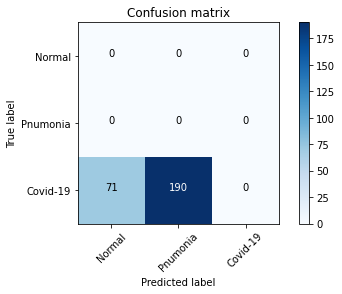

In [15]:
FN_preds = phase2_model.predict(FN_x)
FN_preds = np.rint(FN_preds).astype("int")
FN_preds = FN_preds.reshape(len(index_02))
cm3 = confusion_matrix(FN_y,FN_preds)
plot_confusion_matrix(cm3,["Normal","Pnumonia","Covid-19"] )

## FINAL CONFUSION MATRIX OF ALL 3 CLASSES

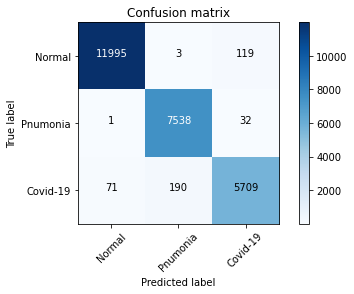

In [16]:
cm =[[cm2[0,0] , cm2[0,1] , len(index_20)],
    [cm2[1,0] , cm2[1,1] , len(index_21)],
    [cm3[2,0] , cm3[2,1] , cm1[1,1]]]
cm = np.array(cm)
plot_confusion_matrix(cm,["Normal","Pnumonia","Covid-19"] )

## FINAL ACCURACY

In [17]:
final_accuracy = (cm[0,0]+cm[1,1]+cm[2,2]) / np.sum(cm)
print("Final Accuracy = ""{:.2%}".format(final_accuracy))

Final Accuracy = 98.38%
